# COVID-19 Voice Detection
[Data Information]   
Data Source: https://dacon.io/competitions/official/235910/overview/description   
Raw Data Type : wav, csv

[Voice Data]   
train_wav : 3805개   
test_wav : 5732개   
unlabeled_wav : 1867개   

[Voice Data Format]   
CFG = {   
    'SR' : 16000,     # 주파수(Sample_rate)   
    'N_MFCC' : 15,    # MFCC 벡터를 추출할 개수   
    'SEED' : 41,      # 시드(Random Seed)   
    'N_MELS' : 128    # 고주파 대역 스케일(Mel Scale)   
}   

[Csv Data]   
train_csv : (3805,6)   
test_csv : (5732,5)   
unlabeled_csv : (1867,5)   

[Version]   
1st Advanced MFCC Feature, f1_score, MLP, Semi-Supervised Learning

## 0. Setting

### Path Check

In [51]:
pwd

'C:\\myPyCode\\Code lion\\COVID-19 Voice Detection'

In [52]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: A494-C8A8

 C:\myPyCode\Code lion\COVID-19 Voice Detection 디렉터리

2022-08-23  오후 04:23    <DIR>          .
2022-08-23  오후 04:23    <DIR>          ..
2022-08-23  오후 03:07    <DIR>          .ipynb_checkpoints
2022-08-23  오전 09:42           446,594 COVID-19 Voice Detection 0824.ipynb
2022-08-23  오후 04:23           992,115 COVID-19 Voice Detection MLP Semi Supervised first function ver.ipynb
2022-08-23  오후 04:23           566,504 COVID-19 Voice Detection MLP Semi Supervised.ipynb
2022-08-23  오전 10:37           464,557 COVID-19 Voice Detection MLP.ipynb
2022-08-22  오후 05:46           638,567 COVID-19 Voice Detection_0823.ipynb
2022-08-23  오후 04:04    <DIR>          data
2022-08-23  오후 01:53    <DIR>          docs
2022-08-22  오후 05:40    <DIR>          low version
2022-08-23  오후 04:05    <DIR>          model_save
               5개 파일           3,108,337 바이트
               7개 디렉터리  10,469,064,704 바이트 남음


### Library Call

In [3]:
# pip install librosa

In [4]:
# pip install xgboost

In [5]:
# pip install lightgbm

In [1]:
# 상용 라이브러리
from glob import glob
import os
import pandas as pd
import numpy as np
import datetime as dt
import time
from tqdm import tqdm
import librosa
import random
import IPython

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
# sckit-learn preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

# ML Model Library
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC ,LinearSVC
from sklearn.ensemble import  RandomForestClassifier ,AdaBoostClassifier ,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
# from xgboost import XGBoostClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance

# Clf Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, precision_recall_curve

### User Function Definition

In [2]:
# ------------- WAV File Load & Preprocessing ------------- #
# Global Constant Definition
root_dir = 'C:\\myPyCode\\Code lion\\COVID-19 Voice Detection'
CFG = {
    'SR' : 16000,     # 주파수(Sample_rate)
    'N_MFCC' : 15,    # MFCC 벡터를 추출할 개수
    'SEED' : 41,      # 시드(Random Seed)
    'N_MELS' : 128    # 고주파 대역 스케일(Mel Scale)
}

# Fixing Every Random Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

# MFCC(Mel-Frequency Cepstral Coefficient) : 음성데이터를 다루기 쉬운 형태로 피처화
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
    root_folder = './data'
    
    # Save Folder Existence Check
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    
    # Filter Constant Definition
    hop_length = CFG['SR'] * 0.01
    n_fft = CFG['SR'] * 0.025
    win_length = n_fft
    
    # MFCC Feature Extraction
    features = []
    for uid in tqdm(df['id']):
        # WAV File path Definition
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # Melspectrogram Extraction
        mels = librosa.feature.melspectrogram(y, sr = sr, n_mels = CFG['N_MELS'])
        
        # Log Transformation
        S = np.abs(mels)
        log_S = librosa.power_to_db(S, ref = np.max)
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, S=log_S, sr=sr, n_mfcc=CFG['N_MFCC'],
                                    n_fft = n_fft, win_length = win_length, hop_length = hop_length)

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

# One-Hot Encoding
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded, columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

# ------------- WAV File Visualization ------------- #
# WAV Plot
def wav_plot(y, sr):
    time = np.linspace(0, len(y)/sr, len(y))
    fig, ax = plt.subplots()
    ax.plot(time, y, color = 'g')
    ax.set_xlabel('Time')
    ax.set_ylabel('Voice')
    plt.title('WAV Plot')
    plt.show()

# WAV Display
def wav_display(y, sr):
    return IPython.display.Audio(data = y, rate = sr)


# ------------- ML Modeling ------------- #
# ML GridSearchCV
def ML_search(X_train,y_train,X_test,y_test):
    lr = LogisticRegression(random_state=42)
    svm = SVC(random_state=42)
    rf  = RandomForestClassifier(random_state=42)
    dt = DecisionTreeClassifier(random_state=42)
    gus = GaussianNB()
    knn = KNeighborsClassifier()
    lin_svc = LinearSVC(random_state=42)
    ada = AdaBoostClassifier(random_state=42)
    grd  = GradientBoostingClassifier(random_state=42)
    lgbm = LGBMClassifier(random_state=42)
    mlp = MLPClassifier(random_state=42)
    
    models = [lr, svm, rf, dt, gus, knn, lin_svc, ada, grd, lgbm, mlp]
    models_result = []
    
    for model in models:
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        pre = precision_score(y_test,pred)
        rec = recall_score(y_test,pred)
        f1 = f1_score(y_test,pred)
        acc = accuracy_score(y_test,pred)
        models_result.append([model,acc,f1,pre,rec])
        
    df = pd.DataFrame(models_result, columns=['name','acc','f1','precision','recall'])
    return df

# Get MLPClassifier Format
def get_mlp_format(model):
    print('n_features :',model.n_features_in_)
    print('n_iter :',model.n_iter_)
    print('n_layers :',model.n_layers_)
    print('n_outputs :',model.n_outputs_)
    print('out_activation :',model.out_activation_)
    return None

# MLP Post Tuning
def mlp_post_tuning(y_pred_proba_1,lower,upper):
    post_result = pd.DataFrame(columns=['acc','pre','rec','f1'])
    proba_grid = np.arange(lower,upper,0.01)
    for proba in proba_grid:
        ele =  np.where(y_pred_proba_1 < proba, 0, 1)
        ele_result = get_clf_eval(y_valid, ele)
        post_result = pd.concat([post_result,pd.DataFrame(ele_result,index=['acc','pre','rec','f1']).T],axis=0)
    post_result.index = proba_grid
    post_result.reset_index(inplace=True)
    post_result.rename(columns={'index':'proba'},inplace=True)
    return post_result

# ------------- Performance Evaluation Metrics ------------- #
# Get Clf Evaluation Metrics
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
    return [acc, pre, rec, f1]        
        
# 정확도 재현율 곡선
def precision_recall_curve_plot(y_test,pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    plt.axvline(x=0.5, label='Normal Threshold', linestyle=':', alpha=0.8, color='green')
    
    start,end = plt.xlim()
    plt.title('Precision Recall Curve', size=20)
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# ROC 곡선 
def roc_curve_plot(y_test, pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
    
    plt.figure(figsize=(8,6))
    plt.plot(fprs, tprs, label='ROC')
    plt.plot([0,1],[0,1],linestyle='--', label='Random', color='k')
    
    start, end = plt.xlim()
    plt.title('Roc Auc Curve', size=20)
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()
    plt.show()

## 1. Data Load

In [4]:
# CSV data load
train_csv = pd.read_csv('data/train_data.csv')
test_csv = pd.read_csv('data/test_data.csv')
unlabeled_csv = pd.read_csv('data/unlabeled_data.csv')

print(train_csv.shape, test_csv.shape, unlabeled_csv.shape)
train_csv.head()

(3805, 6) (5732, 5) (1867, 5)


,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19
0,1,24,female,0,1,0
1,2,51,male,0,0,0
2,3,22,male,0,0,0
3,4,29,female,1,0,0
4,5,23,male,0,0,0


In [9]:
test_csv.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,3806,48,female,1,0
1,3807,24,female,0,0
2,3808,29,male,0,0
3,3809,39,female,0,0
4,3810,34,male,0,0


In [10]:
unlabeled_csv.head()

,id,age,gender,respiratory_condition,fever_or_muscle_pain
0,9538,35,male,1,0
1,9539,40,female,0,1
2,9540,33,male,0,0
3,9541,35,male,0,0
4,9542,54,female,0,0


In [11]:
# # MFCC(Mel-Frequency Cepstral Coefficient) Feature 
# get_mfcc_feature(train_csv.copy(), 'train', 'MFCC/train_mfcc_data_added.csv')
# get_mfcc_feature(test_csv.copy(), 'test', 'MFCC/test_mfcc_data_added.csv')
# get_mfcc_feature(unlabeled_csv.copy(), 'unlabeled', 'MFCC/unlabeled_mfcc_data_added.csv')

In [5]:
# Train & Test Data Load

# wav 파일의 MFCC Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv('data/MFCC/train_mfcc_data_added2.csv')
test_df = pd.read_csv('data/MFCC/test_mfcc_data_added2.csv')
unlabeled_df = pd.read_csv('data/MFCC/unlabeled_mfcc_data_added2.csv')

print(train_df.shape, test_df.shape, unlabeled_df.shape)
train_df.head()

(3805, 38) (5732, 37) (1867, 37)


,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_mean1,mfcc_mean2,mfcc_mean3,mfcc_mean4,...,mfcc_mean23,mfcc_mean24,mfcc_mean25,mfcc_mean26,mfcc_mean27,mfcc_mean28,mfcc_mean29,mfcc_mean30,mfcc_mean31,mfcc_mean32
0,1,24,female,0,1,0,-689.78260,30.519340,-20.314620,-6.689037,...,-2.679408,2.454339,-1.176284,2.314316,-0.339533,2.514414,-4.784704,1.239072,-1.556883,-1.548770
1,2,51,male,0,0,0,-646.08820,54.141323,-1.748550,-9.437218,...,-7.248304,1.238724,-6.894967,-1.810403,-7.259594,0.715028,-1.372265,-1.760624,-2.735180,1.134191
2,3,22,male,0,0,0,-763.64870,46.675842,-22.771933,-3.527923,...,-0.136723,-1.707353,2.649277,1.208829,-0.033701,-1.008729,-0.687254,-0.472232,0.850565,0.353839
3,4,29,female,1,0,0,-723.56230,47.762012,-8.256503,-2.891349,...,-0.389230,4.033148,-2.658165,2.867083,1.679876,2.136411,0.289792,1.709179,-0.592465,1.754549
4,5,23,male,0,0,0,-813.31647,7.509357,-7.762264,2.567660,...,-0.279361,-0.292287,-1.559679,0.328864,-1.053423,0.844060,-0.788913,1.182740,-0.527028,1.208361


In [13]:
# Single Sample
sample_idx = np.random.choice(np.arange(1,train_df.shape[0]),1)[0]
sample_path = 'data/train/' + str(sample_idx).zfill(5) + '.wav'
print(sample_path)
y,sr = librosa.load(sample_path, sr = CFG['SR'])

data/train/01985.wav


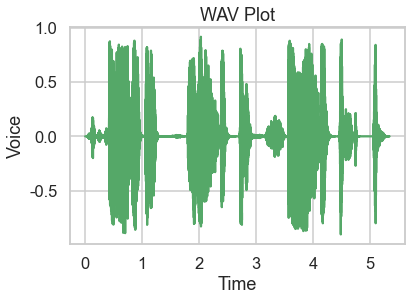

In [14]:
# WAV Sample Visualization
wav_plot(y, sr)

In [15]:
# WAV Sample Display
wav_display(y, sr)

0    3499
1     306
Name: covid19, dtype: int64


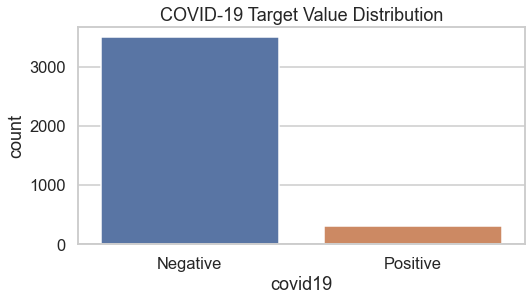

In [16]:
# Target value Distribution
print(train_df['covid19'].value_counts())

plt.figure(figsize=(8,4))
plt.title('COVID-19 Target Value Distribution')
sns.countplot(train_df['covid19'])
plt.xticks([0,1],['Negative', 'Positive'])
plt.show()

## 2. Data Preprocessing

In [6]:
# Data Split
train_x = train_df.drop(columns=['id', 'covid19'])
train_y = train_df['covid19']
test_x = test_df.drop(columns=['id'])
unlabeled_x = unlabeled_df.drop(columns=['id'])

train_x.shape, train_y.shape, test_x.shape, unlabeled_x.shape

((3805, 36), (3805,), (5732, 36), (1867, 36))

In [7]:
# OneHotEncoding
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_x['gender'].values.reshape(-1,1))
train_x = onehot_encoding(ohe, train_x)
test_x = onehot_encoding(ohe, test_x)
unlabeled_x = onehot_encoding(ohe, unlabeled_x)

train_x.shape, test_x.shape, unlabeled_x.shape

((3805, 38), (5732, 38), (1867, 38))

In [19]:
# # StandardScaler
# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(train_x)
# test_scaled = scaler.transform(test_x)
# unlabeled_scaled = scaler.transform(unlabeled_x)

In [8]:
# Train Valid Data Split
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, stratify=train_y, random_state=42)

print('X_train.shape :',X_train.shape)
print('y_train.shape :',y_train.shape)
print('X_test.shape :',X_valid.shape)
print('y_test.shape :',y_valid.shape)

X_train.shape : (3044, 38)
y_train.shape : (3044,)
X_test.shape : (761, 38)
y_test.shape : (761,)


## 3. Semi-Supervised Learning

In [9]:
# MLPClassifier
semi_model = MLPClassifier(activation = 'relu', solver = 'adam', random_state=42)

In [10]:
# Training
start_time = time.time()
semi_model.fit(X_train, y_train)
end_time = time.time()

In [11]:
# Training Time Measurements
duration = end_time - start_time
result = dt.timedelta(seconds=duration)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:01


In [12]:
# Parameter coefficients 
print("Neural Network Parameter's format",semi_model.coefs_[0].shape, semi_model.coefs_[1].shape)

Neural Network Parameter's format (38, 100) (100, 1)


In [13]:
# Get MLPClassifier Format
get_mlp_format(semi_model)

n_features : 38
n_iter : 31
n_layers : 3
n_outputs : 1
out_activation : logistic


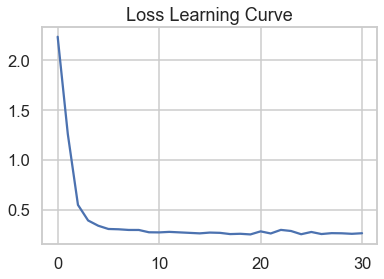

In [14]:
plt.title('Loss Learning Curve')
plt.plot(semi_model.loss_curve_ )
plt.show()

In [15]:
# Test Data Prediction Probability
y_pred_proba = semi_model.predict_proba(X_valid)
y_pred_proba_1 = y_pred_proba[:,1]

In [16]:
# Post Tuning
post_result = mlp_post_tuning(y_pred_proba_1,0.01,0.8)

[[ 12 688]
 [  0  61]]
정확도 :0.0959, 정밀도 :0.0814, 재현율 :1.0000, F1 :0.1506
[[ 28 672]
 [  3  58]]
정확도 :0.1130, 정밀도 :0.0795, 재현율 :0.9508, F1 :0.1466
[[ 65 635]
 [  3  58]]
정확도 :0.1616, 정밀도 :0.0837, 재현율 :0.9508, F1 :0.1538
[[122 578]
 [  7  54]]
정확도 :0.2313, 정밀도 :0.0854, 재현율 :0.8852, F1 :0.1558
[[226 474]
 [  9  52]]
정확도 :0.3653, 정밀도 :0.0989, 재현율 :0.8525, F1 :0.1772
[[324 376]
 [ 16  45]]
정확도 :0.4849, 정밀도 :0.1069, 재현율 :0.7377, F1 :0.1867
[[411 289]
 [ 21  40]]
정확도 :0.5926, 정밀도 :0.1216, 재현율 :0.6557, F1 :0.2051
[[468 232]
 [ 23  38]]
정확도 :0.6649, 정밀도 :0.1407, 재현율 :0.6230, F1 :0.2296
[[505 195]
 [ 28  33]]
정확도 :0.7070, 정밀도 :0.1447, 재현율 :0.5410, F1 :0.2284
[[524 176]
 [ 29  32]]
정확도 :0.7306, 정밀도 :0.1538, 재현율 :0.5246, F1 :0.2379
[[549 151]
 [ 30  31]]
정확도 :0.7622, 정밀도 :0.1703, 재현율 :0.5082, F1 :0.2551
[[565 135]
 [ 30  31]]
정확도 :0.7832, 정밀도 :0.1867, 재현율 :0.5082, F1 :0.2731
[[584 116]
 [ 30  31]]
정확도 :0.8081, 정밀도 :0.2109, 재현율 :0.5082, F1 :0.2981
[[595 105]
 [ 32  29]]
정확도 :0.8200, 정밀도 :0.2164, 재현

In [17]:
# Post Tuning Result
post_result.sort_values(by='f1', ascending=False).head()

,proba,acc,pre,rec,f1
23,0.24,0.892247,0.327869,0.327869,0.327869
24,0.25,0.894875,0.333333,0.311475,0.322034
21,0.22,0.883049,0.3,0.344262,0.320611
22,0.23,0.885677,0.30303,0.327869,0.314961
14,0.15,0.839685,0.239316,0.459016,0.314607


In [18]:
# Semi-Supervised Model
semi_pred_proba = semi_model.predict_proba(unlabeled_x)
semi_pred_proba_1 = semi_pred_proba[:,1]

In [19]:
# Semi-Supervised Model
semi_proba = 0.24
semi_prediction =  np.where(semi_pred_proba_1 < semi_proba, 0, 1)

In [20]:
# Unlabeled Data Labeling
unlabeled_x['covid19'] = -1
unlabeled_x['covid19'] = semi_prediction

0    1563
1     304
Name: covid19, dtype: int64


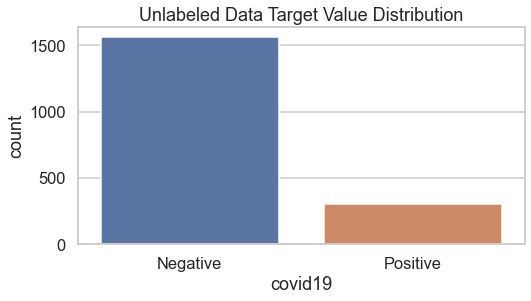

In [21]:
# Unlabeled Data value Distribution
print(unlabeled_x['covid19'].value_counts())

plt.figure(figsize=(8,4))
plt.title('Unlabeled Data Target Value Distribution')
sns.countplot(unlabeled_x['covid19'])
plt.xticks([0,1],['Negative', 'Positive'])
plt.show()

In [22]:
# Unlabeled Data Split
unlabeled_y = unlabeled_x['covid19']
unlabeled_x = unlabeled_x.drop(['covid19'], axis = 1)

unlabeled_x.shape, unlabeled_y.shape

((1867, 38), (1867,))

In [23]:
# Total DataSet Definition
all_x = pd.concat([train_x, unlabeled_x], axis=0)
all_y = pd.concat([train_y, unlabeled_y], axis=0)

all_x.shape, all_y.shape

((5672, 38), (5672,))

0    5062
1     610
Name: covid19, dtype: int64


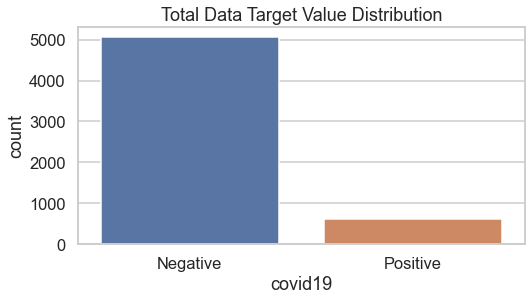

In [24]:
# Total Data value Distribution
print(all_y.value_counts())

plt.figure(figsize=(8,4))
plt.title('Total Data Target Value Distribution')
sns.countplot(all_y)
plt.xticks([0,1],['Negative', 'Positive'])
plt.show()

## 4. ML Modeling

In [25]:
# MLPClassifier
model = MLPClassifier(activation = 'relu', solver = 'adam', random_state=42)

In [26]:
# Training
start_time = time.time()
model.fit(all_x, all_y)
end_time = time.time()

In [27]:
# Training Time Measurements
duration = end_time - start_time
result = dt.timedelta(seconds=duration)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:00:01


In [28]:
# Parameter coefficients 
print("Neural Network Parameter's format",model.coefs_[0].shape, model.coefs_[1].shape)

Neural Network Parameter's format (38, 100) (100, 1)


In [29]:
# Get MLPClassifier Format
get_mlp_format(model)

n_features : 38
n_iter : 42
n_layers : 3
n_outputs : 1
out_activation : logistic


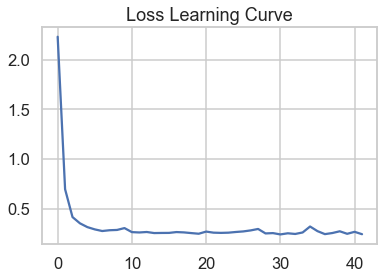

In [30]:
plt.title('Loss Learning Curve')
plt.plot(model.loss_curve_ )
plt.show()

## 5. Performance Evaluation

In [31]:
# Test Data Prediction
y_pred = model.predict(X_valid)
result = y_valid.to_frame().rename(columns={'covid19':'True'})
result['Pred'] = y_pred
print('result.shape :',result.shape)
result.head()

result.shape : (761, 2)


,True,Pred
3497,0,0
2167,0,0
2466,0,0
3744,0,0
223,0,0


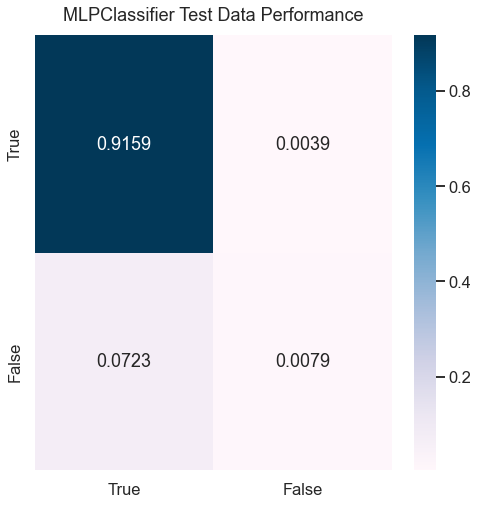

In [32]:
# Test Data Prediction Confusion Matrix
plt.figure(figsize=(8,8))
plt.title('MLPClassifier Test Data Performance',y=1.02)
sns.heatmap(confusion_matrix(result['True'],result['Pred'],normalize='all'), cmap='PuBu', annot=True, fmt='.4f')
plt.xticks([0.5,1.5],['True','False'])
plt.yticks([0.5,1.5],['True','False'])
plt.show()

In [33]:
# Get Clf Metrics
_ = get_clf_eval(result['True'],result['Pred'])

[[697   3]
 [ 55   6]]
정확도 :0.9238, 정밀도 :0.6667, 재현율 :0.0984, F1 :0.1714


In [34]:
# Test Data Prediction Probability
y_pred_proba = model.predict_proba(X_valid)
y_pred_proba_1 = y_pred_proba[:,1]

Roc Auc Score : 0.717


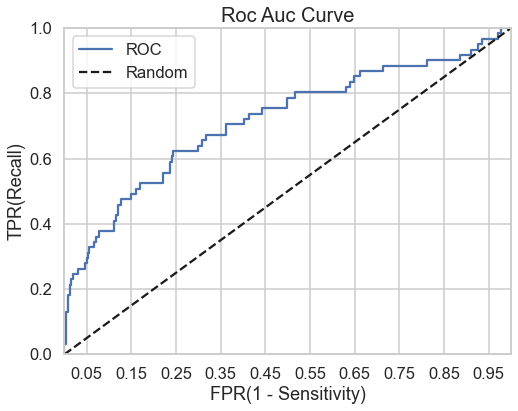

In [35]:
# ROC CURVE
print('Roc Auc Score :',np.round(roc_auc_score(y_valid,y_pred_proba_1),4))
roc_curve_plot(y_valid, y_pred_proba_1)

Precision : 0.6667
Recall : 0.0984


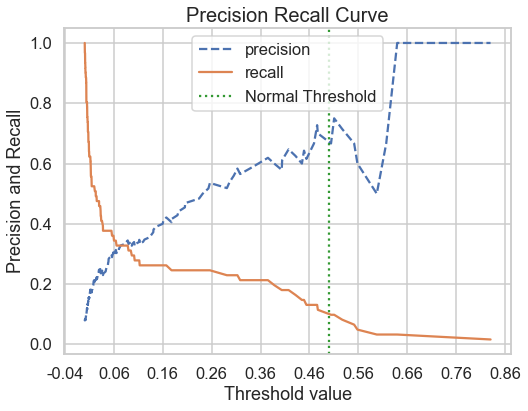

In [36]:
# Precision Recall Curve
print('Precision :',np.round(precision_score(y_valid,y_pred),4))
print('Recall :',np.round(recall_score(y_valid,y_pred),4))
precision_recall_curve_plot(y_valid,y_pred_proba_1)

## 6. Post Tuning

In [37]:
# Post Tuning
post_result = mlp_post_tuning(y_pred_proba_1,0.01,0.8)

[[499 201]
 [ 23  38]]
정확도 :0.7057, 정밀도 :0.1590, 재현율 :0.6230, F1 :0.2533
[[582 118]
 [ 30  31]]
정확도 :0.8055, 정밀도 :0.2081, 재현율 :0.5082, F1 :0.2952
[[613  87]
 [ 33  28]]
정확도 :0.8423, 정밀도 :0.2435, 재현율 :0.4590, F1 :0.3182
[[627  73]
 [ 38  23]]
정확도 :0.8541, 정밀도 :0.2396, 재현율 :0.3770, F1 :0.2930
[[643  57]
 [ 38  23]]
정확도 :0.8752, 정밀도 :0.2875, 재현율 :0.3770, F1 :0.3262
[[650  50]
 [ 40  21]]
정확도 :0.8817, 정밀도 :0.2958, 재현율 :0.3443, F1 :0.3182
[[656  44]
 [ 41  20]]
정확도 :0.8883, 정밀도 :0.3125, 재현율 :0.3279, F1 :0.3200
[[660  40]
 [ 41  20]]
정확도 :0.8936, 정밀도 :0.3333, 재현율 :0.3279, F1 :0.3306
[[663  37]
 [ 42  19]]
정확도 :0.8962, 정밀도 :0.3393, 재현율 :0.3115, F1 :0.3248
[[665  35]
 [ 43  18]]
정확도 :0.8975, 정밀도 :0.3396, 재현율 :0.2951, F1 :0.3158
[[667  33]
 [ 44  17]]
정확도 :0.8988, 정밀도 :0.3400, 재현율 :0.2787, F1 :0.3063
[[670  30]
 [ 45  16]]
정확도 :0.9014, 정밀도 :0.3478, 재현율 :0.2623, F1 :0.2991
[[671  29]
 [ 45  16]]
정확도 :0.9028, 정밀도 :0.3556, 재현율 :0.2623, F1 :0.3019
[[673  27]
 [ 45  16]]
정확도 :0.9054, 정밀도 :0.3721, 재현

In [38]:
# Post Tuning Result
post_result.sort_values(by='f1', ascending=False).head()

,proba,acc,pre,rec,f1
24,0.25,0.921156,0.517241,0.245902,0.333333
7,0.08,0.893561,0.333333,0.327869,0.330579
23,0.24,0.919842,0.5,0.245902,0.32967
30,0.31,0.925099,0.583333,0.229508,0.329412
4,0.05,0.875164,0.2875,0.377049,0.326241


## 7. Test Submission 

In [ ]:
# Sample Submission DataFrame
submit = pd.read_csv('data/sample_submission.csv')
print('submit :',submit.shape)
submit.head()

In [ ]:
# Submission Data Prediction
y_sub_pred = model.predict_proba(test_x)[:,1]
sub_proba = 0.25
sub_prediction = np.where(y_sub_pred < sub_proba, 0, 1)

In [ ]:
# Final Submission DataFrame
submit['covid19'] = sub_prediction
print('sub_result.shape :',submit.shape)
submit.head()

In [ ]:
# Submission Export
file = 'data/submission/submit_0823_added2.csv'
submit.to_csv(file,index=False)

In [ ]:
# Submission Read
pd.read_csv(file).head()